In [1]:
import types
import pandas as pd
import quandl # import data

df_data_1 = quandl.get("OPEC/ORB", start_date="2003-01-01", end_date="2020-06-30")
df_data_1.head()


,Value
Date,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


Data Source

U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, January 10, 2018.

In [2]:
# if data has missing values use below code
# df_data_1 = df_data_1[df_data_1 != "."] 
print (df_data_1.shape)
print(df_data_1)

(4512, 1)
            Value
Date             
2003-01-02  30.05
2003-01-03  30.83
2003-01-06  30.71
2003-01-07  29.72
2003-01-08  28.86
...           ...
2020-06-24  38.17
2020-06-25  37.18
2020-06-26  37.99
2020-06-29  37.34
2020-06-30  38.22

[4512 rows x 1 columns]


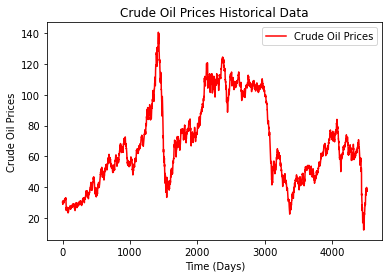

In [3]:
import matplotlib.pyplot as plt
df_data_1_plot = df_data_1.values
# print(df_data_1_plot)
# for i in range(len(df_data_1_plot)):
#     df_data_1_plot[i][0] = float(df_data_1_plot[i][0])
# Visualising the Data
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [4]:
#import packages
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import load_model

In [5]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 700
timesteps = 20

In [6]:
length = len(df_data_1)
print (length)

#test set will be 10% of entire data set  
length *= 1 - 0.1
print (length)

4512
4060.8


In [7]:
#get the length of training data set 
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print (x)
    return (max(train_length_values))

In [8]:
length = get_train_length(df_data_1, batch_size, 0.1)
print (length)

3968
4032
4032


In [9]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = df_data_1[0:upper_train]
training_set = df_data_1_train.values
training_set.shape

(4072, 1)

In [10]:
# Feature Scaling i.e we scale each and every value between 0 and 1 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(4072, 1)

In [11]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print (length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print (len(X_train))
print (len (y_train))
print (np.array(X_train).shape)
print (np.array(y_train).shape)

4052
4032
4032
(4032, 20)
(4032, 20)


In [12]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print (X_train.shape)
print (y_train.shape)

(4032, 20, 1)
(4032, 20, 1)


In [13]:
# Building the LSTM
# Importing the Keras libraries and packages

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.models import Model
import h5py

In [14]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 20, 1)]             0         
_________________________________________________________________
lstm (LSTM)                  (64, 20, 10)              480       
_________________________________________________________________
lstm_1 (LSTM)                (64, 20, 10)              840       
_________________________________________________________________
dense (Dense)                (64, 20, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 1st LSTM Layer 
parameters = 4 * 10 * (1 + 10 + 1)
print (parameters)

480


In [16]:
# 2nd LSTM Layer 
parameters = 4 * 10 * (10 + 10 + 1)
print( parameters)

840


In [17]:
print("Epoch: " + str(epochs))
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mae.reset_states()

Epoch: 700
Epoch: 0
63/63 [==============================] - 0s 6ms/step - loss: 0.1112
Epoch: 1
63/63 [==============================] - 0s 6ms/step - loss: 0.1143
Epoch: 2
63/63 [==============================] - 0s 6ms/step - loss: 0.0971
Epoch: 3
63/63 [==============================] - 0s 6ms/step - loss: 0.0887
Epoch: 4
63/63 [==============================] - 0s 6ms/step - loss: 0.0816
Epoch: 5
63/63 [==============================] - 0s 6ms/step - loss: 0.0747
Epoch: 6
63/63 [==============================] - 0s 6ms/step - loss: 0.0690
Epoch: 7
63/63 [==============================] - 0s 6ms/step - loss: 0.0651
Epoch: 8
63/63 [==============================] - 0s 6ms/step - loss: 0.0628
Epoch: 9
63/63 [==============================] - 0s 7ms/step - loss: 0.0613
Epoch: 10
63/63 [==============================] - 0s 6ms/step - loss: 0.0603
Epoch: 11
63/63 [==============================] - 0s 7ms/step - loss: 0.0594
Epoch: 12
63/63 [==============================] - 0s 6ms/step 

In [18]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print (x)
    return (max(test_length_values))

In [19]:
test_length = get_test_length(df_data_1, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print (testset_length)

4328
4392
4456
4456
384


In [20]:
print (upper_train, upper_test, len(df_data_1))

4072 4496 4512


In [21]:
# construct test set

#subsetting
df_data_1_test = df_data_1[upper_train:upper_test] 
test_set = df_data_1_test.values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [22]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print (predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print (predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print (y_test.shape)

(384, 20, 1)
(384, 20)
(364, 1)


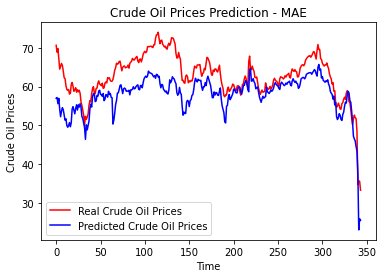

In [23]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)], color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test[0:len(y_test) - timesteps], color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [24]:

import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

5.814888596335307


In [25]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

4.851576411446859
